Implement gibbs sampler for bayesian gmm

In [2]:

import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import numpy as np
from sklearn.mixture import GaussianMixture
import numpy as np
from scipy.stats import  wishart, dirichlet, invwishart, multivariate_normal
import matplotlib.pyplot as plt
from sklearn.metrics.cluster import adjusted_rand_score as ari

# source: https://github.com/is0383kk/GMM-Gibbs/blob/main/gmm_gibbs.ipynb

In [3]:
############################## Loading a Data Set ##############################
print("Loading a Data Set")
x_nd_1 = np.loadtxt("../data/data_3_clusters.txt") # Observation1(Corresponds to x_1 in the graphical model)
z_truth_n = np.loadtxt("../data/data_3_clusters_labels.txt") # True label (True z_n)
K = 3 # Number of clusters
N = len(x_nd_1) # Number of data
D = len(x_nd_1[0]) # Number of dimention
print(f"Number of clusters: {K}"); print(f"Number of data: {len(x_nd_1)}");
iteration = 20 # Iteration of gibbssampling
ARI = np.zeros((iteration)) # ARI per iteration
x_i = x_nd_1

Loading a Data Set
Number of clusters: 3
Number of data: 250


In [4]:
# github code

# set z values
alpha0 = 100
alpha = np.ones(K) * alpha0/K # Uniform prior
pi_k = dirichlet.rvs(alpha=alpha, size=1).flatten()
z_nk = np.random.multinomial(n=1, pvals=pi_k, size=N)
_, z_n = np.where(z_nk == 1)

In [5]:
from importlib import reload
import gibbs_gmm
reload(gibbs_gmm)

<module 'gibbs_gmm' from '/Users/david/Documents/mastersCode/ubm/tuts/gaussian_mixture_models/gibbs/gibbs_gmm.py'>

In [6]:
gibbs_sampler = gibbs_gmm.MixGaussGibbsSampler(x_i, z_n)

In [7]:
# gibbs_sampler_output = gibbs_sampler.perform_gibbs_sampling(50)

In [40]:
class GMMGibbsSampler():
    def __init__(self, X, K, burn_in=5, iterations=50, **kwargs):
        """
        [] input
        X = data n x d
        K = expected amount of components

        [] params = pi, z, mu, Sigma
        init z and pi using uniform alpha, mu and sigma using data and z assignments

        [] hyper-params = alpha, m0, V0, nu0, S0
        for uniform priors we set
        alpha0 -> small value
        m0 -> mean of init assignments
        V0 -> large eye matrix
        nu0 -> K + 1
        S0 -> data scatter matrix

        [] ss
        nk - count of data in each k
        x_bar - mean of data in each k
        """

        self.X = X  # data n x d
        self.K = K  # expected no of states
        self.burn_in = burn_in
        self.iterations = iterations
        self.N = X.shape[0] # length of data
        self.D = X.shape[1] # dimension of data

        self.Z_true = kwargs.get("Z_true")

        # set alpha to uniform prior and draw pi and z
        self.alpha0 = np.ones(K) * 1000/self.K # Uniform prior
        self.pi = dirichlet.rvs(alpha=self.alpha0, size=1).flatten()
        Z_mat = np.random.multinomial(n=1, pvals=self.pi, size=self.N) # N x K 'one-hot vectors'
        _, self.Z = np.where(Z_mat == 1) # N x 1 component number

        # sufficient stats
        self.nk = np.zeros(self.K, dtype=int)
        self.x_bar = np.zeros((self.K, self.D), dtype=float)
        for k in range(K):
            self.nk[k] = np.sum(self.Z == k)
            self.x_bar[k] = np.mean(self.X[self.Z == k], axis=0)

        # init mu and Sigma
        self.mu = np.zeros((self.K, self.D))
        self.sigma = np.zeros((self.K, self.D, self.D))
        self.lambdas = np.zeros((self.K, self.D, self.D))
        diagsig = np.zeros((self.K, self.D, self.D)) # scatter matrix
        for k in range(K):
            x_k = self.X[self.Z == k]
            sig_bar = np.cov(x_k.T, bias=True)
            diagsig[k] = np.diag(np.diag(sig_bar))
            self.mu[k] = self.x_bar[k]
            self.sigma[k] = sig_bar
            self.lambdas[k] = np.linalg.inv(sig_bar)

        # Hyper parameters
        # Mu
        self.m0 = self.x_bar # K x D
        self.V0 = [np.eye(self.D) * 1000 for _ in range(K)] # K x D x D
        # Sigma
        self.S0 = diagsig # K x D x D
        self.nu0 = self.K + 1  # 1 Degrees of freedom IW

        self.mu_trace = []
        self.sigma_trace = []
        self.pi_trace = []
        self.ARI = np.zeros((self.iterations))

    def fit(self):
        self.ARI = np.zeros((self.iterations))
        print('starting gibbs sampling')
        for it in range(self.iterations):
            self.gibbs_sweep()

            # save trace
            if it < self.burn_in:
                self.mu_trace.append(self.mu)
                self.sigma_trace.append(self.sigma)
                self.pi_trace.append(self.pi)

            # Calculate ARI
            if self.Z_true is not None:
                self.ARI[it] = np.round(ari(self.Z_true, self.Z), 3)
                print(f"ARI:{self.ARI[it]}")

        print('completed gibbs sampling')

    def get_model_likelihood(self):
        pass

    # one sweep of git sampler, return variables sampled
    def gibbs_sweep(self):
        # [1] sample params using assignments
        for k in range(self.K):
            # mu
            Vk = (np.linalg.inv(np.linalg.inv(self.V0[k]) + self.nk[k] * np.linalg.inv(self.sigma[k])))
            term1 = np.dot(np.linalg.inv(self.sigma[k]), self.nk[k] * self.x_bar[k])
            term2 = np.dot(np.linalg.inv(self.V0[k]), self.m0[k])
            mk = (np.dot(Vk, term1 + term2))
            # sample mu
            self.mu[k] = np.random.multivariate_normal(mean=mk, cov=Vk, size=1).flatten()

            # sigma
            dif = (self.X[self.Z == k] - self.mu[k])
            Sk = (self.S0[k] + (np.dot(dif.T, dif)))
            nuk = self.nu0 + self.nk[k]
            # sample sigma
            self.sigma[k] = invwishart.rvs(size=1, df=nuk, scale=Sk)

        # sample pi
        alpha_k = self.nk + self.alpha0
        self.pi = dirichlet.rvs(size=1, alpha=alpha_k).flatten()

        # [2] sample assignments using params
        # responsibilities
        res = np.zeros((self.N, self.K))
        for n in range(self.N):
            for k in range(self.K):
                res[n, k] = self.pi[k] * multivariate_normal.pdf(self.X[n], mean=self.mu[k], cov=self.sigma[k])
            res[n, :] /= np.sum(res[n, :])

        # Sample z
        Z_mat = np.zeros((self.N, self.K))
        for n in range(self.N):
            Z_mat[n] = np.random.multinomial(n=1, pvals=res[n], size=1).flatten()
        _, self.Z = np.where(Z_mat == 1)

        # [3] update ss
        for k in range(K):
            self.nk[k] = np.sum(self.Z == k)
            self.x_bar[k] = np.mean(self.X[self.Z == k], axis=0)

        return self.pi, self.mu, self.sigma


In [45]:
my_gibbs = GMMGibbsSampler(x_i, 3, Z_true=z_truth_n)

In [46]:
my_gibbs.fit()

starting gibbs sampling
ARI:0.014
ARI:0.03
ARI:0.102
ARI:0.221
ARI:0.357
ARI:0.433
ARI:0.511
ARI:0.535
ARI:0.519
ARI:0.522
ARI:0.53
ARI:0.549
ARI:0.531
ARI:0.524
ARI:0.537
ARI:0.548
ARI:0.651
ARI:0.734
ARI:0.889
ARI:0.988
ARI:1.0
ARI:1.0
ARI:1.0
ARI:1.0
ARI:1.0
ARI:1.0
ARI:1.0
ARI:1.0
ARI:1.0
ARI:1.0
ARI:1.0
ARI:1.0
ARI:1.0
ARI:1.0
ARI:1.0
ARI:1.0
ARI:1.0
ARI:1.0
ARI:1.0
ARI:1.0
ARI:1.0
ARI:1.0
ARI:1.0
ARI:1.0
ARI:1.0
ARI:1.0
ARI:1.0
ARI:1.0
ARI:1.0
ARI:1.0
completed gibbs sampling


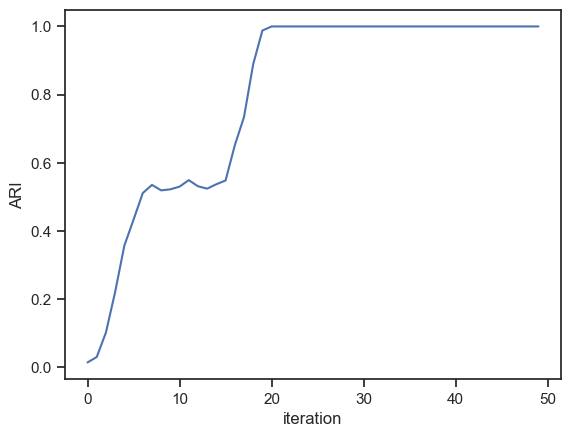

In [49]:
plt.plot(range(0,len(my_gibbs.ARI)), my_gibbs.ARI, marker="None")
plt.xlabel('iteration')
plt.ylabel('ARI')
#plt.savefig("./image/ari.png")
plt.show()
plt.close()

In [28]:
# setting hyper-params, alpha, m0, V0, S0, nu0
# as well as hyper-params, set mu, sigma first then hyper-params, then finally pie which relies on alpha

# [] Get z values
alpha0 = 100
alpha = np.ones(K) * alpha0/K # Uniform prior
pi_k = dirichlet.rvs(alpha=alpha, size=1).flatten()
z_nk = np.random.multinomial(n=1, pvals=pi_k, size=N)
_, z_n = np.where(z_nk == 1)



In [ ]:

mu_k = np.zeros((K, D))
sigma_k = np.zeros((K, D, D))
lambda_k = np.zeros((K, D, D))
N_k = np.zeros(K)
diagsig = np.zeros((K, D, D))

for k in range(K):

    N_k[k] = np.sum(z_n == k)
    x_k = x_i[z_n == k]
    x_bar = np.mean(x_k, axis=0)

    mu_k[k] = x_bar
    sig_bar = np.cov(x_k.T, bias=True)
    sig_diagonal = np.diag(np.diag(sig_bar))
    sigma_k[k] = sig_bar
    lambda_k[k] = np.linalg.inv(sig_bar)
    diagsig[k] = sig_diagonal

In [25]:
# Hyperparameters for prior on component means (mu)
m0 = np.zeros(D)  # D x 1
V0 = np.eye(D) * 1000 # D x D

# Hyperparameters for prior on component covariances (Sigma)
S0 = diagsig # Scale matrix D x D
nu0 = 4  # Degrees of freedom for the Inverse-Wishart prior

starting it:  0
ARI:0.008
starting it:  1
ARI:0.06
starting it:  2
ARI:0.136
starting it:  3
ARI:0.3
starting it:  4
ARI:0.372
starting it:  5
ARI:0.451
starting it:  6
ARI:0.484
starting it:  7
ARI:0.524
starting it:  8
ARI:0.556
starting it:  9
ARI:0.58
starting it:  10
ARI:0.613
starting it:  11
ARI:0.727
starting it:  12
ARI:0.801
starting it:  13
ARI:0.858
starting it:  14
ARI:0.965
starting it:  15
ARI:0.988
starting it:  16
ARI:1.0
starting it:  17
ARI:1.0
starting it:  18
ARI:1.0
starting it:  19
ARI:1.0
starting it:  20
ARI:1.0
starting it:  21
ARI:1.0
starting it:  22
ARI:1.0
starting it:  23
ARI:1.0
starting it:  24
ARI:1.0
starting it:  25
ARI:1.0
starting it:  26
ARI:1.0
starting it:  27
ARI:1.0
starting it:  28
ARI:1.0
starting it:  29
ARI:1.0
starting it:  30
ARI:1.0
starting it:  31
ARI:1.0
starting it:  32
ARI:1.0
starting it:  33
ARI:1.0
starting it:  34
ARI:1.0
starting it:  35
ARI:1.0
starting it:  36
ARI:1.0
starting it:  37
ARI:1.0
starting it:  38
ARI:1.0
startin

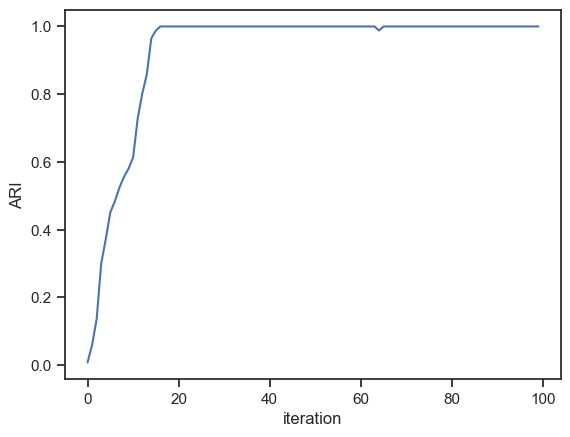

In [26]:
iteration = 100
ARI = np.zeros((iteration))

for i in range(iteration):
    print('starting it: ', i)

    N_k = np.zeros(K)  # Initialize N_k array
    for k in range(K):
        N_k[k] = np.sum(z_n == k)

    x_bar = []
    for k in range(K):
        x_k = x_i[z_n == k]
        x_bar.append(np.mean(x_k, axis=0))

    for k in range(K):
        # sample mu
        V_k = (np.linalg.inv(np.linalg.inv(V0) + N_k[k] * np.linalg.inv(sigma_k[k])))
        term1 = np.dot(np.linalg.inv(sigma_k[k]), N_k[k] * x_bar[k])
        term2 = np.dot(np.linalg.inv(V0), m0) # always 0 with current prior
        m_k = (np.dot(V_k, term1 + term2))
        # sample mu
        mu_k[k] = np.random.multivariate_normal(mean=m_k, cov=V_k, size=1).flatten()

        # sample sigma
        mask = (z_n == k)
        dif = (x_i[mask] - mu_k[k])
        s_k = (S0[k] + (np.dot(dif.T, dif)))
        nu_k = nu0 + N_k[k]
        # sample sigma
        sigma_k[k] = invwishart.rvs(size=1, df=nu_k, scale=s_k)


    # sample pi
    alpha_k = np.sum(z_nk, axis=0) + alpha
    pi_k = dirichlet.rvs(size=1, alpha=alpha_k).flatten()

    # get responsibilities
    responsibilities = np.zeros((N, K))
    for n in range(N):
        for k in range(K):
            responsibilities[n, k] = pi_k[k] * multivariate_normal.pdf(x_i[n], mean=mu_k[k], cov=sigma_k[k])
        responsibilities[n, :] /= np.sum(responsibilities[n, :])

    # Sample z
    for n in range(N):
        z_nk[n] = np.random.multinomial(n=1, pvals=responsibilities[n], size=1).flatten()
    _, z_n = np.where(z_nk == 1)

    # Calculate ARI
    ARI[i] = np.round(ari(z_truth_n, z_n), 3)
    print(f"ARI:{ARI[i]}")

# plot ARI
plt.plot(range(0,iteration), ARI, marker="None")
plt.xlabel('iteration')
plt.ylabel('ARI')
#plt.savefig("./image/ari.png")
plt.show()
plt.close()